<a href="https://colab.research.google.com/github/berkaykarlik/whoIsThatPokemon_CNN/blob/master/vgg_19_notebookVer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from keras import models
from keras import layers
from keras.optimizers import SGD
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from shutil import copy
from shutil import rmtree

Using TensorFlow backend.


In [2]:
from google.colab import files
uploaded = files.upload()
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [0]:
!kaggle datasets download -d lantian773030/pokemonclassification
!unzip pokemonclassification.zip

In [0]:
path = 'PokemonData'
if os.path.exists('train'):
    rmtree('train')
if os.path.exists('validate'):
    rmtree('validate')
if os.path.exists('test'):
    rmtree('test')

os.mkdir('train')
os.mkdir('validate')
os.mkdir('test')

In [5]:
image_count = 0
class_count = 0
classes = []
for i in os.listdir(path):
    classes.append(i)
    class_path = os.path.join(path, i)
    if not os.path.exists(os.path.join('train', i)):
        os.mkdir(os.path.join('train', i))
    if not os.path.exists(os.path.join('validate', i)):
        os.mkdir(os.path.join('validate', i))
    if not os.path.exists(os.path.join('test', i)):
        os.mkdir(os.path.join('test', i))
    image_paths = []
    for j in os.listdir(class_path):
        image_paths.append(os.path.join(class_path, j))
        image_count += 1
    np.random.shuffle(image_paths)
    training_path = image_paths[:int(len(image_paths) * .80)]
    test_path = image_paths[int(len(image_paths) * .80):]
    valid_path = training_path[int(len(training_path) * .80):]
    training_path = training_path[:int(len(training_path) * .80)]
    for j in training_path:
        copy(j, os.path.join('train', i))
    for j in valid_path:
        copy(j, os.path.join('validate', i))
    for j in test_path:
        copy(j, os.path.join('test', i))
    class_count += 1
print(image_count)
print(class_count)

6837
150


In [6]:
train_data_generator = ImageDataGenerator()
train_data = train_data_generator.flow_from_directory(directory='train', target_size=(224,224))

validate_data_generator = ImageDataGenerator()
validate_data = validate_data_generator.flow_from_directory(directory='validate', target_size=(224,224))

test_data_generator = ImageDataGenerator()
test_data = test_data_generator.flow_from_directory(directory='test', target_size=(224,224))


Found 4250 images belonging to 150 classes.
Found 1142 images belonging to 150 classes.
Found 1428 images belonging to 150 classes.


In [7]:
pre_trained_model = VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False, pooling='avg')
pre_trained_model.trainable = False
print(pre_trained_model.summary())


80142336/80134624 [==============================] - 4s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [8]:
prediction_layer = layers.Dense(150)
total_model = models.Sequential([pre_trained_model, prediction_layer])
total_model.compile(loss='categorical_crossentropy', optimizer = SGD(lr=0.01, momentum=0.9), metrics = ['accuracy'])
print(total_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 512)               20024384  
_________________________________________________________________
dense_1 (Dense)              (None, 150)               76950     
Total params: 20,101,334
Trainable params: 76,950
Non-trainable params: 20,024,384
_________________________________________________________________
None


In [9]:
history = total_model.fit(train_data, validation_data=validate_data, epochs=5)

Epoch 1/5
133/133 [==============================] - 43s 324ms/step - loss: 6.8306 - accuracy: 0.0085 - val_loss: 6.5780 - val_accuracy: 0.0079
Epoch 2/5
133/133 [==============================] - 35s 264ms/step - loss: 6.2393 - accuracy: 0.0082 - val_loss: 6.3821 - val_accuracy: 0.0079
Epoch 3/5
133/133 [==============================] - 36s 268ms/step - loss: 6.1057 - accuracy: 0.0082 - val_loss: 5.4820 - val_accuracy: 0.0079
Epoch 4/5
133/133 [==============================] - 35s 264ms/step - loss: 5.9734 - accuracy: 0.0082 - val_loss: 7.2002 - val_accuracy: 0.0079
Epoch 5/5
133/133 [==============================] - 35s 267ms/step - loss: 5.7856 - accuracy: 0.0082 - val_loss: 5.9015 - val_accuracy: 0.0079


In [10]:
accuracy = total_model.evaluate(test_data)

45/45 [==============================] - 11s 239ms/step


In [11]:
print("Accuracy:" , accuracy)

Accuracy: [5.916184425354004, 0.007703081239014864]


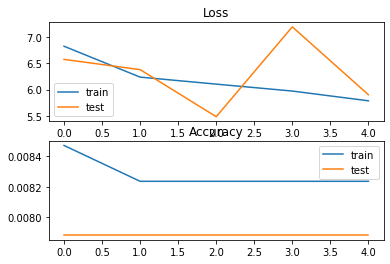

In [12]:
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()